In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_root = ('/content/drive/MyDrive/data/train')

In [ ]:
IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels

In [ ]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
TRAINING_DATA_DIR = str(data_root)

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [ ]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR, subset= 'validation', shuffle=True, target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,subset='training',shuffle=True,target_size=IMAGE_SHAPE)
    


Found 3327 images belonging to 9 classes.
Found 13316 images belonging to 9 classes.


In [ ]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 9))

In [ ]:
label_batch[0:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
print (train_generator.class_indices)

{'Tomato___Early_blight': 0, 'Tomato___Late_blight': 1, 'Tomato___Leaf_Mold': 2, 'Tomato___Septoria_leaf_spot': 3, 'Tomato___Spider_mites Two-spotted_spider_mite': 4, 'Tomato___Target_Spot': 5, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 6, 'Tomato___Tomato_mosaic_virus': 7, 'Tomato___healthy': 8}


In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

Tomato___Early_blight
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___healthy

In [ ]:
import tensorflow_hub as hub

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
  output_shape=[1280],
  trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import numpy as np

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(train_generator, 
   epochs=10,
   verbose=1,
   steps_per_epoch=steps_per_epoch,
   validation_data=valid_generator,
   validation_steps=val_steps_per_epoch).history

Epoch 1/10
417/417 [==============================] - 3428s 8s/step - loss: 0.9139 - acc: 0.6842 - val_loss: 0.4894 - val_acc: 0.8365
Epoch 2/10
417/417 [==============================] - 76s 183ms/step - loss: 0.5064 - acc: 0.8301 - val_loss: 0.4237 - val_acc: 0.8560
Epoch 3/10
417/417 [==============================] - 76s 182ms/step - loss: 0.4268 - acc: 0.8542 - val_loss: 0.3729 - val_acc: 0.8741
Epoch 4/10
417/417 [==============================] - 75s 179ms/step - loss: 0.3980 - acc: 0.8647 - val_loss: 0.3687 - val_acc: 0.8726
Epoch 5/10
417/417 [==============================] - 73s 175ms/step - loss: 0.3709 - acc: 0.8738 - val_loss: 0.3493 - val_acc: 0.8795
Epoch 6/10
417/417 [==============================] - 73s 174ms/step - loss: 0.3577 - acc: 0.8750 - val_loss: 0.3380 - val_acc: 0.8804
Epoch 7/10
417/417 [==============================] - 73s 175ms/step - loss: 0.3435 - acc: 0.8774 - val_loss: 0.3213 - val_acc: 0.8870
Epoch 8/10
417/417 [==============================] - 72

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

104/104 [==============================] - 15s 139ms/step - loss: 0.3086 - acc: 0.8912
Final loss: 0.31
Final accuracy: 89.12%


In [ ]:
history = model.fit_generator(train_generator, 
                    epochs=10, 
                    validation_data=valid_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
417/417 [==============================] - 72s 173ms/step - loss: 0.2870 - acc: 0.8974 - val_loss: 0.3099 - val_acc: 0.8909
Epoch 2/10
417/417 [==============================] - 73s 175ms/step - loss: 0.2863 - acc: 0.8975 - val_loss: 0.3160 - val_acc: 0.8861
Epoch 3/10
417/417 [==============================] - 74s 176ms/step - loss: 0.2813 - acc: 0.8991 - val_loss: 0.3210 - val_acc: 0.8870
Epoch 4/10
417/417 [==============================] - 72s 174ms/step - loss: 0.2908 - acc: 0.8958 - val_loss: 0.3296 - val_acc: 0.8879
Epoch 5/10
417/417 [==============================] - 71s 170ms/step - loss: 0.2882 - acc: 0.8960 - val_loss: 0.3240 - val_acc: 0.8900
Epoch 6/10
417/417 [==============================] - 70s 169ms/step - loss: 0.2824 - acc: 0.8998 - val_loss: 0.3147 - val_acc: 0.8903
Epoch 7/10
417/417 [==============================] - 71s 171ms/step - loss: 0.2745 - acc: 0.9031 - val_loss: 0.3081 - val_acc: 0.8936
Epoch 8/10
417/417 [==============================] - 7

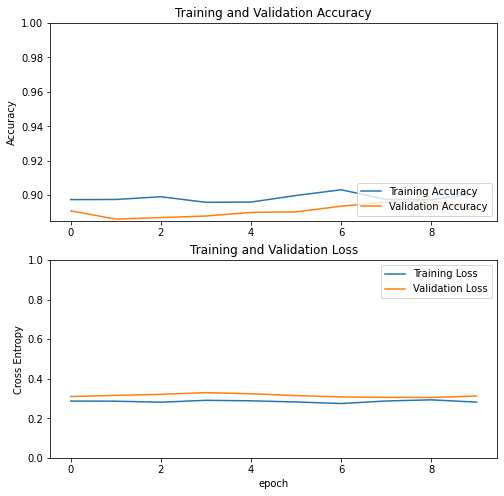

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Tomato___Early_Blight' 'Tomato___Late_Blight' 'Tomato___Leaf_Mold'
 'Tomato___Septoria_Leaf_Spot'
 'Tomato___Spider_Mites Two-Spotted_Spider_Mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_Mosaic_Virus'
 'Tomato___Healthy']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 9)


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Tomato___Spider_Mites Two-Spotted_Spider_Mite'
 'Tomato___Septoria_Leaf_Spot' 'Tomato___Early_Blight'
 'Tomato___Tomato_Mosaic_Virus' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Early_Blight'
 'Tomato___Healthy' 'Tomato___Tomato_Mosaic_Virus'
 'Tomato___Spider_Mites Two-Spotted_Spider_Mite' 'Tomato___Healthy'
 'Tomato___Septoria_Leaf_Spot' 'Tomato___Septoria_Leaf_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Septoria_Leaf_Spot'
 'Tomato___Leaf_Mold' 'Tomato___Early_Blight' 'Tomato___Healthy'
 'Tomato___Healthy' 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Tomato___Spider_Mites Two-Spotted_Spider_Mite'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Healthy'
 'Tomato___Tomato_Mosaic_Virus' 'Tomato___Leaf_Mold'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Late_Blight'
 'Tomato___Septoria_Leaf_Spot' 'Tomato___Early_Blight'
 'Tomato___Septoria_Leaf_Spot' 'Tomato___Target_Spot']


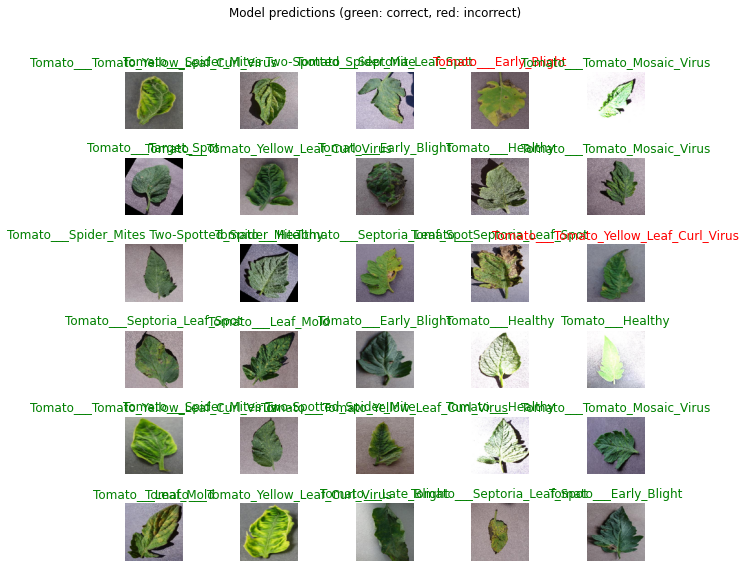

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
 plt.subplot(6,5,n+1)
 plt.imshow(val_image_batch[n])
 color = 'green' if predicted_ids[n] == true_label_ids[n] else 'red'
 plt.title(predicted_labels[n].title(), color=color)
 plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer('https://tfhub.dev/google/efficientnet/b1/classification/1', 
  output_shape=[1280],
  trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1000)              7856232   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 9)                 9009      
                                                                 
Total params: 7,865,241
Trainable params: 9,009
Non-trainable params: 7,856,232
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(train_generator, 
   epochs=10,
   verbose=1,
   steps_per_epoch=steps_per_epoch,
   validation_data=valid_generator,
   validation_steps=val_steps_per_epoch).history

Epoch 1/10
417/417 [==============================] - 91s 203ms/step - loss: 0.9666 - acc: 0.6748 - val_loss: 0.4348 - val_acc: 0.8524
Epoch 2/10
417/417 [==============================] - 83s 198ms/step - loss: 0.5047 - acc: 0.8266 - val_loss: 0.3503 - val_acc: 0.8798
Epoch 3/10
417/417 [==============================] - 82s 197ms/step - loss: 0.4263 - acc: 0.8572 - val_loss: 0.3301 - val_acc: 0.8873
Epoch 4/10
417/417 [==============================] - 82s 197ms/step - loss: 0.3746 - acc: 0.8730 - val_loss: 0.2978 - val_acc: 0.8981
Epoch 5/10
417/417 [==============================] - 82s 198ms/step - loss: 0.3550 - acc: 0.8770 - val_loss: 0.2989 - val_acc: 0.8972
Epoch 6/10
417/417 [==============================] - 82s 197ms/step - loss: 0.3466 - acc: 0.8815 - val_loss: 0.2696 - val_acc: 0.9095
Epoch 7/10
417/417 [==============================] - 82s 197ms/step - loss: 0.3439 - acc: 0.8816 - val_loss: 0.2668 - val_acc: 0.9077
Epoch 8/10
417/417 [==============================] - 8

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

104/104 [==============================] - 17s 160ms/step - loss: 0.2693 - acc: 0.9029
Final loss: 0.27
Final accuracy: 90.29%


In [ ]:
history = model.fit_generator(train_generator, 
                    epochs=10, 
                    validation_data=valid_generator)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


417/417 [==============================] - 83s 199ms/step - loss: 0.3404 - acc: 0.8873 - val_loss: 0.2532 - val_acc: 0.9161
Epoch 2/10
417/417 [==============================] - 83s 198ms/step - loss: 0.3303 - acc: 0.8877 - val_loss: 0.2623 - val_acc: 0.9116
Epoch 3/10
417/417 [==============================] - 82s 198ms/step - loss: 0.3264 - acc: 0.8872 - val_loss: 0.2705 - val_acc: 0.9032
Epoch 4/10
417/417 [==============================] - 83s 198ms/step - loss: 0.3244 - acc: 0.8889 - val_loss: 0.2623 - val_acc: 0.9107
Epoch 5/10
417/417 [==============================] - 83s 198ms/step - loss: 0.3339 - acc: 0.8898 - val_loss: 0.2597 - val_acc: 0.9116
Epoch 6/10
417/417 [==============================] - 83s 198ms/step - loss: 0.3240 - acc: 0.8897 - val_loss: 0.2893 - val_acc: 0.9038
Epoch 7/10
417/417 [==============================] - 83s 198ms/step - loss: 0.3310 - acc: 0.8876 - val_loss: 0.2566 - val_acc: 0.9131
Epoch 8/10
417/417 [==============================] - 83s 198ms/st

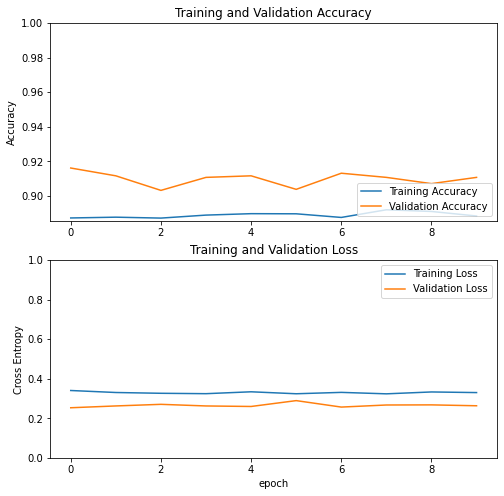

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()